In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pylab as pl

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
N_ITERS = 60
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

In [3]:
class CAModel(nn.Module):
    def __init__(self, n_channels=16, device=None, fire_rate=0.5):
        super().__init__()
        
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_channels = n_channels
        self.fire_rate = fire_rate
        
        self.layers = nn.Sequential(nn.Conv2d(n_channels*3, 128, 1),
                                    nn.ReLU(),
                                    nn.Conv2d(128, n_channels, 1))
        
    
    def wrap_edges(self, x):
        return F.pad(x, (1,1,1,1), 'circular', 0)

    
    def get_living_mask(self, x):
        alpha = x[:, 3:4, :, :]
        return F.max_pool2d(self.wrap_edges(alpha), 3, stride=1) > 0.1


    def perceive(self, x, angle=0.):
        identity = torch.tensor([[0.,0.,0.],
                                 [0.,1.,0.],
                                 [0.,0.,0.]])
        dx = torch.tensor([[-0.125,0.,0.125],
                           [-0.25 ,0.,0.25 ],
                           [-0.125,0.,0.125]])
        dy = dx.T
        
        angle = torch.tensor(angle)
        c, s = torch.cos(angle), torch.sin(angle)
        dx, dy = c*dx - s*dy, s*dx + c*dy
        
        
        all_filters = torch.stack((identity, dx, dy))
        all_filters_batch = all_filters.repeat(self.n_channels,1,1).unsqueeze(1)
        all_filters_batch = all_filters_batch.to(self.device)
        return F.conv2d(self.wrap_edges(x), all_filters_batch, groups=self.n_channels)
    

    def forward(self, x, angle=0., step_size=1.):
        pre_life_mask = self.get_living_mask(x)
        
        dx = self.layers(self.perceive(x, angle)) * step_size
        update_mask = torch.rand(x[:,:1,:,:].size(), device=self.device) < self.fire_rate
        x += dx*update_mask.float()
        
        post_life_mask = self.get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask

        return x * life_mask.float()
    
    
    def evolve(self, x, iters, angle=0., step_size=1.):
        for i in range(iters):
            x = self.forward(x, angle=0., step_size=1)
        
        return x

    
ca = CAModel(n_channels=1)

x = torch.ones((3,1,5,5)).to("cuda")
ca.perceive(x).shape

torch.Size([3, 3, 5, 5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


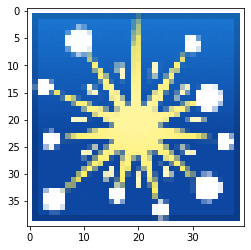

In [4]:
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T

transforms = torch.nn.Sequential(
    T.Resize((TARGET_SIZE, TARGET_SIZE))
)

target = read_image("splash.png", ImageReadMode.RGB_ALPHA).float()
target = transforms(target)
target = target/255.

pl.imshow(np.asarray(target.permute(1,2,0)))

In [5]:
class SamplePool:
    def __init__(self):
        image_size = TARGET_SIZE + TARGET_PADDING
        start_point = torch.zeros((POOL_SIZE, N_CHANNELS, image_size, image_size))
        start_point[:, 3, image_size//2, image_size//2] = 1.
        self.images = start_point
        self.size = POOL_SIZE

        
    def sample(self, batch_size):
        idx = np.random.choice(self.size, batch_size, False)
        return self.images[idx], idx
    
    def update(self, new_images, idx):
        self.images[idx] = new_images

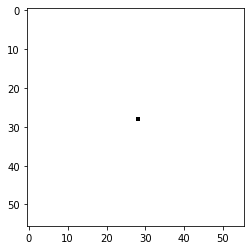

In [32]:
pool = SamplePool()

def CenterCrop(image):
    return T.CenterCrop(TARGET_SIZE)(image)

def imshow(image, center_crop=False):
    if center_crop:
        image = CenterCrop(image)
    pl.imshow(np.asarray(image.cpu().permute(1,2,0)[:,:,:4]))
    
imshow(pool.sample(1)[0][0])

In [30]:
def loss_fn(x):
    return torch.mean((center_crop(x)[:, :4, :, :] - target)**2)

target = target.cpu()
loss_fn(pool.sample(16)[0])

tensor(0.4648)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

target = target.to(device)
model = CAModel().to(device)
pool = SamplePool()
optimizer = torch.optim.Adam(model.parameters())

model.train()

losses = []
for i in range(10000):
    inputs, indexes = pool.sample(BATCH_SIZE)
    inputs = inputs.to(device)
    optimizer.zero_grad()
    
    for j in range(N_ITERS):
        inputs = model(inputs)
    
    loss = loss_fn(inputs)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

/home/lettera/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1301.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


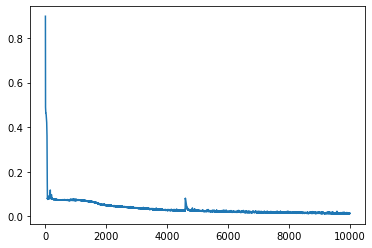

In [9]:
pl.plot(np.asarray(losses))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


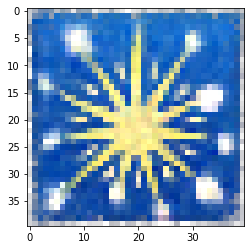

In [33]:
model.eval()

with torch.no_grad():
    x, _ = pool.sample(1)
    x = x.to(device)
    
    for j in range(N_ITERS):
        x = model(x)

        
imshow(x[0], center_crop=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


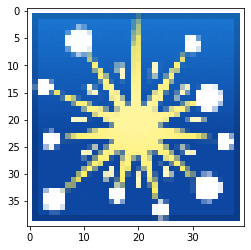

In [34]:
imshow(target)